# Processing Force Plate Data
## Calculating Jump Height from a Countermovement Jump (CMJ)

Force plate output from CMJs taken at 4 time periods during a season: 

1.	Calculate the jump height using the Impulse-Momentum Theorem for each trial. 

2.	Average the 3 trials for each testing session. 

3.	Plot the average jump heights for the 4 sessions. 

## Import Force Plate Files

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tkinter import filedialog


# Get file directory
folder_path = filedialog.askdirectory()

# Create an empty dictionary to store the force plate files
forceplate_dict = {}

# Loop through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        # Extract the file name without the extension
        name_without_extension = os.path.splitext(filename)[0]

        # Construct the full file path
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Store the force plate files in the dictionary with the file name as the key
        forceplate_dict[name_without_extension] = df

## Function to Calculate Jump Height using Impulse-Momentum Theorem
1. Calculates body weight from 1 second of quiet standing
2. Finds when force curve exceeds 5 SD of body weight
3. Sets onset of countermovement as 30 ms before 5 SD threshold is breached 
4. Sets off plate time when force data = 0
5. Calculates impulse of force curve between onset and off plate time using trapezoid rule
6. Calculates impulse of body weight between onset and off plate time
7. Calculates net impulse as force impulse minus body weight impulse
8. Calculates take-off velocity from equation: Net Impulse = m(in Kg) * velocity
9. Calculate jump height using take-off velocity: Jump Height = 1/2 * (velocity^2 / gravity)

In [2]:
# Set the sampling frequency (in Hz)
SAMPLING_FREQUENCY = 1000


# Define a function to calculate jump height for a single jump
def calculate_jump_height(df):
    # Extract force and time
    force_data = df.iloc[:, 3].values
    time = df.iloc[:, 0].values
    
    # Calculate body weight (N) as the average of the first second of data
    body_weight = np.mean(force_data[:SAMPLING_FREQUENCY])
    threshold_sd = 5 * np.std(force_data[:SAMPLING_FREQUENCY])  # Threshold 5*SD of body weight

    # Body mass in kg
    body_mass_kg = body_weight/(9.81)

    # Identify onset time
    onset_threshold_n = body_weight - threshold_sd # below 5 sd
    onset_threshold_p = body_weight + threshold_sd # above 5 sd
    # Initialize variables to track loop progress
    start_index = SAMPLING_FREQUENCY
    found_index = None
    # Start the loop after 1 second of data
    while start_index < len(force_data):
        if force_data[start_index] > onset_threshold_p:  # if force curve is positive to start movement
            found_index = start_index
            break
        elif force_data[start_index] < onset_threshold_n: # if force curve is negative to start movement
            found_index = start_index
            break
        start_index += 1
    # Calculate onset time 30 ms before curve is 5 SD above/below body weight
    onset_time = found_index - int(0.03 * SAMPLING_FREQUENCY)

    # Identify off plate time and impulse time
    off_plate_time = np.argmax(force_data == 0)
    impulse_time = (off_plate_time - onset_time)/SAMPLING_FREQUENCY
    
    # Calculate impulse as the area under the force curve between onset and off plate times
    impulse_trap = np.trapz(force_data[onset_time:off_plate_time], dx=1/SAMPLING_FREQUENCY)     
        
    # Calculate impulse due to body weight (N)
    impulse_body_weight = body_weight * impulse_time

    # Net impulse (impulse normalized to body weight)
    net_impulse = impulse_trap - impulse_body_weight
    
    # Impulse = m(in Kg) * velocity
    takeoff_velocity = net_impulse / body_mass_kg

    # Calculate jump height using velocity: Jump Height = 1/2 * (velocity^2 / gravity)
    jump_height = 0.5 * (takeoff_velocity**2 / 9.81)
    
    return jump_height


# Create a dictionary to store jump heights for each jump
jump_heights = {}

# Calculate jump heights for each jump in the dictionary
for key, df in forceplate_dict.items():
    jump_height = calculate_jump_height(df)
    jump_heights[key] = jump_height

# Print the calculated jump heights
for key, height in jump_heights.items():
    print(f"Jump '{key}': Height = {height:.2f} meters")

Jump 'CMJ_1_1': Height = 0.31 meters
Jump 'CMJ_1_2': Height = 0.36 meters
Jump 'CMJ_1_3': Height = 0.30 meters
Jump 'CMJ_2_1': Height = 0.37 meters
Jump 'CMJ_2_2': Height = 0.30 meters
Jump 'CMJ_2_3': Height = 0.35 meters
Jump 'CMJ_3_1': Height = 0.33 meters
Jump 'CMJ_3_2': Height = 0.39 meters
Jump 'CMJ_3_3': Height = 0.39 meters
Jump 'CMJ_4_1': Height = 0.34 meters
Jump 'CMJ_4_2': Height = 0.39 meters
Jump 'CMJ_4_3': Height = 0.40 meters


## Calculate Average Jump Height per Session

In [3]:
# Create a dictionary to store jump heights for each session
session_jump_heights = {}

# Aggregate and Calculate Jump Heights by Session
for key, df in forceplate_dict.items():
    session_name = "_".join(key.split('_')[:2])  # Extract session name (e.g., 'CMJ_1')
    jump_height = calculate_jump_height(df)
    
    if session_name not in session_jump_heights:
        session_jump_heights[session_name] = [jump_height]
    else:
        session_jump_heights[session_name].append(jump_height)

# Calculate and print the average jump heights for each session
for session, heights in session_jump_heights.items():
    print(f"Session {session}:")
    for jump_num, height in enumerate(heights, start=1):
        jump_id = f'{session}_{jump_num}'
        print(f"Jump '{jump_id}': Height = {height:.2f} meters")
    average_height = np.mean(heights)
    print(f"Average Jump Height for Session {session}: {average_height:.2f} meters")
    print()

Session CMJ_1:
Jump 'CMJ_1_1': Height = 0.31 meters
Jump 'CMJ_1_2': Height = 0.36 meters
Jump 'CMJ_1_3': Height = 0.30 meters
Average Jump Height for Session CMJ_1: 0.33 meters

Session CMJ_2:
Jump 'CMJ_2_1': Height = 0.37 meters
Jump 'CMJ_2_2': Height = 0.30 meters
Jump 'CMJ_2_3': Height = 0.35 meters
Average Jump Height for Session CMJ_2: 0.34 meters

Session CMJ_3:
Jump 'CMJ_3_1': Height = 0.33 meters
Jump 'CMJ_3_2': Height = 0.39 meters
Jump 'CMJ_3_3': Height = 0.39 meters
Average Jump Height for Session CMJ_3: 0.37 meters

Session CMJ_4:
Jump 'CMJ_4_1': Height = 0.34 meters
Jump 'CMJ_4_2': Height = 0.39 meters
Jump 'CMJ_4_3': Height = 0.40 meters
Average Jump Height for Session CMJ_4: 0.38 meters



## Plot Average Jump Heights

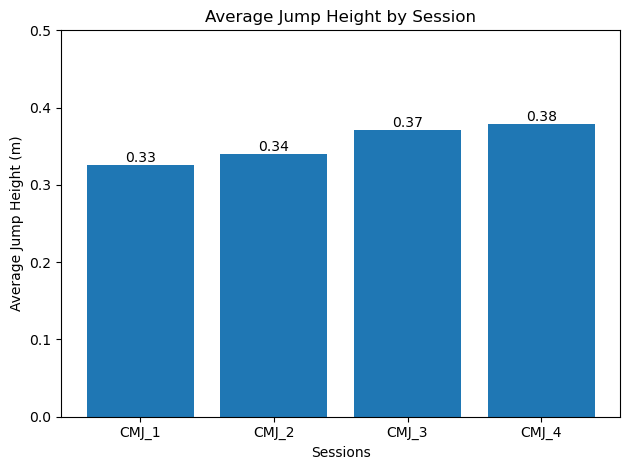

In [4]:
# Extract session names and average jump heights
sessions = list(session_jump_heights.keys())
average_heights = [np.mean(heights) for heights in session_jump_heights.values()]

# Create a bar graph
plt.bar(sessions, average_heights)
plt.xlabel("Sessions")
plt.ylabel("Average Jump Height (m)")
plt.title("Average Jump Height by Session")
plt.ylim(0,0.5)

# Add average jump height values at the top of each bar
for i in range(len(sessions)):
    plt.text(sessions[i], average_heights[i], f'{average_heights[i]:.2f}', ha='center', va='bottom')

# Show the bar graph
plt.tight_layout()
plt.show()

### Code for Trouble Shooting

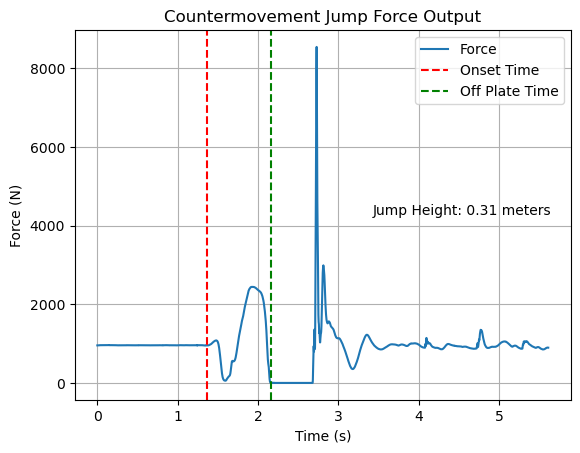

Jump Height: 0.31 meters
Take off Velocity: 2.48 m/s


In [5]:
# Test Code for one trial

# Load force plate data
df_file1 = forceplate_dict["CMJ_1_1"] 

# Set the global sampling frequency (in Hz)
SAMPLING_FREQUENCY = 1000

# Extract time and force columns
time = df_file1.iloc[:, 0].values
force_data = df_file1.iloc[:, 3].values

# Calculate body weight (N) as the average of the first second of data
body_weight = np.mean(force_data[:SAMPLING_FREQUENCY]) 
threshold_sd = 5 * np.std(force_data[:SAMPLING_FREQUENCY])
    
# Body mass in kg
body_mass_kg = body_weight/(9.81)

# Identify onset time
onset_threshold_n = body_weight - threshold_sd # below 5 sd
onset_threshold_p = body_weight + threshold_sd # above 5 sd

# Initialize variables to track loop progress
start_index = SAMPLING_FREQUENCY
found_index = None

# Start the loop after 1 second
while start_index < len(force_data):
    if force_data[start_index] > onset_threshold_p:
        found_index = start_index
        break
    elif force_data[start_index] < onset_threshold_n:
        found_index = start_index
        break
    start_index += 1

# Calculate onset time 30 ms before the found index
onset_time = found_index - int(0.03 * SAMPLING_FREQUENCY)

# Identify off plate time and impulse time
off_plate_time = np.argmax(force_data == 0)
impulse_time = (off_plate_time - onset_time)/SAMPLING_FREQUENCY

# Calculate impulse as the area under the force curve between onset and off plate times
impulse_trap = np.trapz(force_data[onset_time:off_plate_time], dx=1/SAMPLING_FREQUENCY)

# Calculate impulse due to body weight (N)
impulse_body_weight = body_weight * impulse_time

# Net impulse (total impulse normalized to body weight)
net_impulse = impulse_trap - impulse_body_weight

# Impulse = m(in Kg) * velocity
takeoff_velocity = net_impulse / body_mass_kg

# Calculate jump height using velocity: Jump Height = 1/2 * (velocity^2 / gravity)
jump_height = 0.5 * (takeoff_velocity**2 / 9.81)


# Plot the force curve with onset and off plate lines
plt.plot(time, force_data, label='Force')
plt.axvline(x=df_file1.iloc[onset_time, 0], color='r', linestyle='--', label='Onset Time')
plt.axvline(x=df_file1.iloc[off_plate_time, 0], color='g', linestyle='--', label='Off Plate Time')
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.title("Countermovement Jump Force Output")
plt.legend()
plt.grid(True)


# Display calculated jump height on the plot
plt.text(0.6, 0.5, f'Jump Height: {jump_height:.2f} meters', transform=plt.gca().transAxes)

plt.show()

# Print calculated jump height
print(f"Jump Height: {jump_height:.2f} meters")
# Print calculated take off velocity
print(f"Take off Velocity: {takeoff_velocity:.2f} m/s")